# Edgotyping Data Analyses

In [24]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

sys.path.append("../..")
from utils import *

## 1. Loading data

In [2]:
edgotyping_scores_df = pl.read_excel("../1_inputs/VarChAMP1percentEdgotypingScores_SeqConfirmed_ONLY.xlsx")
edgotyping_scores_df

ad_orf_id,ad_mut_id,db_orf_id,db_mut_id,condition_name,retest_batch,media_control,consensus_score,ad_symbol,symbol,aa_change,nt_change,ensembl_gene_id,collection,clinvar_clnsig_clean,gnomad_af,StarStatus,allele_0,final_score,final_score_wt,edgotype,edgotype_wt_2,seq_confirmation,seq_confirmation_wt,db_node_seq_confirmation,combo SWIM+pool,POOL only,SWIM only
i64,i64,i64,i64,str,str,bool,i64,str,str,str,str,str,str,str,f64,i64,str,i64,i64,str,str,i64,i64,i64,bool,bool,bool
145,0,145,200059,"""LWH1""","""VUSAPWT1B2""",false,2,"""PTS""","""PTS""","""Arg25Gln""","""74G>A""","""ENSG00000150787""","""CEGS2""","""1_Pathogenic""",6.9900e-7,2,"""PTS_Arg25Gln""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
145,0,145,200065,"""LWH1""","""VUSAPWT1B2""",false,2,"""PTS""","""PTS""","""Asp116Gly""","""347A>G""","""ENSG00000150787""","""CEGS2""","""3_Conflicting""",0.000004,1,"""PTS_Asp116Gly""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
152,0,5066,201830,"""LWH1""","""VUSAPWT1B2""",false,3,"""TRIM27""","""BAG3""","""Arg258Trp""","""772C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.0004399,2,"""BAG3_Arg258Trp""",3,3,"""not perturbed""","""not perturbed""",1,1,1,true,true,true
152,0,5066,201831,"""LWH1""","""VUSAPWT1B2""",false,0,"""TRIM27""","""BAG3""","""Leu462Pro""","""1385T>C""","""ENSG00000151929""","""CEGS2""","""1_Pathogenic""",null,1,"""BAG3_Leu462Pro""",0,3,"""perturbed""","""perturbed""",1,1,2,true,true,true
152,0,5066,201832,"""LWH1""","""VUSAPWT1B2""",false,2,"""TRIM27""","""BAG3""","""Pro380Ser""","""1138C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.000499,2,"""BAG3_Pro380Ser""",2,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
100080183,0,71191,205704,"""LWH1""","""VUSAPWT6B1""",false,4,"""MEIS3""","""SUOX""","""Ala265Asp""","""794C>A""","""ENSG00000139531""","""CEGS2""","""4_VUS""",0.000042,1,"""SUOX_Ala265Asp""",4,4,"""not perturbed""","""not perturbed""",1,1,1,true,true,true
100080183,0,71191,205705,"""LWH1""","""VUSAPWT6B1""",false,4,"""MEIS3""","""SUOX""","""Gly530Asp""","""1589G>A""","""ENSG00000139531""","""CEGS2""","""1_Pathogenic""",6.8412e-7,null,"""SUOX_Gly530Asp""",4,4,"""not perturbed""","""not perturbed""",1,1,2,true,true,true
100080871,0,5066,201830,"""LWH1""","""VUSAPWT1B2""",false,4,"""PRDM6""","""BAG3""","""Arg258Trp""","""772C>T""","""ENSG00000151929""","""CEGS2""","""2_Benign""",0.0004399,2,"""BAG3_Arg258Trp""",4,3,"""inconclusive""","""inconclusive""",1,1,1,true,true,true


In [3]:
edgotyping_scores_alleles_df = pl.read_excel("../1_inputs/VarChampPillarEdgotypingScoresWithAlleleInfo_ToShare.xlsx")
edgotyping_scores_alleles_df#["seq_confirmed_final"].unique()

id,category,symbol,ccsb_mutation_id,ccsb_allele_id,db_orf_id,cv_allele_id,spdi,clinical_significance_simple,nt_change,aa_change,ensembl_protein_id,aa_change_ensp,ad_orf_id,ad_symbol,standard_batch,retest_pla,retest_pla_full,retest_pos,final_score,final_score_wt,final_score_wt_huri,edgotype,edgotype_wt_2,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final
i64,str,str,str,str,i64,i64,str,str,str,str,str,str,i64,str,str,i64,str,str,str,i64,i64,str,str,i64,i64,i64
1,"""CAVA""","""CTCF""","""CCSBVarC010816""","""ALE00008908""",6173,208297,"""NC_000016.10:67636779:C:T""","""benign""","""1927C>T""","""Pro643Ser""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Pro643Ser""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""F09""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
2,"""CAVA""","""CTCF""","""CCSBVarC010858""","""ALE00014571""",6173,799962,"""NC_000016.10:67626562:C:G""","""Pathogenic""","""1365C>G""","""His455Gln""","""ENSP00000264010.4""","""ENSP00000264010.4:p.His455Gln""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""H09""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
3,"""CAVA""","""CTCF""","""CCSBVarC010870""","""ALE00013232""",6173,260121,"""NC_000016.10:67621454:A:G""","""Pathogenic""","""1220A>G""","""Tyr407Cys""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Tyr407Cys""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""A10""","""2""",2,4,"""NA""","""not perturbed""",1,1,1
4,"""CAVA""","""CTCF""","""CCSBVarC010851""","""ALE00013946""",6173,422102,"""NC_000016.10:67616816:C:T""","""Pathogenic""","""1024C>T""","""Arg342Cys""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Arg342Cys""",9637,"""TRAF2""","""HsVCplarAs1""",1,"""HsVCplarAs1_001""","""G09""","""AA""",2,4,"""NA""","""NA""",1,1,1
6,"""CAVA""","""CTCF""","""CCSBVarC010816""","""ALE00008908""",6173,208297,"""NC_000016.10:67636779:C:T""","""benign""","""1927C>T""","""Pro643Ser""","""ENSP00000264010.4""","""ENSP00000264010.4:p.Pro643Ser""",9016,"""ZMYM6""","""HsVCplarAs6""",1,"""HsVCplarAs6_001""","""C01""","""2""",2,1,"""NA""","""not perturbed""",1,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11163,"""CAVA""","""RAF1""","""CCSBVarC008858""","""ALE00013778""",732,496336,"""NC_000003.12:12604195:A:C""","""Pathogenic""","""775T>G""","""Ser259Ala""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Ser259Ala""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""B02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1
11164,"""CAVA""","""RAF1""","""CCSBVarC008860""","""ALE00011641""",732,28999,"""NC_000003.12:12584624:G:C""","""Pathogenic""","""1837C>G""","""Leu613Val""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Leu613Val""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""C02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1
11165,"""CAVA""","""RAF1""","""CCSBVarC008862""","""ALE00012143""",732,49083,"""NC_000003.12:12599717:C:G""","""Pathogenic""","""1082G>C""","""Gly361Ala""","""ENSP00000251849.4""","""ENSP00000251849.4:p.Gly361Ala""",5462,"""NRAS""","""HsVCplarAs6""",25,"""HsVCplarAs6_025""","""D02""","""NULL""",null,0,"""NULL""","""NULL""",1,1,1


In [4]:
overlapped_cols = set(edgotyping_scores_df.columns).intersection(set(edgotyping_scores_alleles_df.columns))
combined_df = pl.concat([
    edgotyping_scores_df.select(pl.col(overlapped_cols)),
    edgotyping_scores_alleles_df.select(pl.col(overlapped_cols))
], how="vertical_relaxed").with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
)
print("Unique variants profiled:", combined_df.unique(subset="gene_variant"))
display(combined_df)

Unique variants profiled: shape: (968, 11)
┌───────────┬────────────┬────────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ aa_change ┆ final_scor ┆ final_scor ┆ db_orf_id ┆ … ┆ nt_change ┆ symbol ┆ edgotype_ ┆ gene_vari │
│ ---       ┆ e_wt       ┆ e          ┆ ---       ┆   ┆ ---       ┆ ---    ┆ wt_2      ┆ ant       │
│ str       ┆ ---        ┆ ---        ┆ i64       ┆   ┆ str       ┆ str    ┆ ---       ┆ ---       │
│           ┆ i64        ┆ str        ┆           ┆   ┆           ┆        ┆ str       ┆ str       │
╞═══════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ Pro237Ser ┆ 4          ┆ 4          ┆ 7637      ┆ … ┆ 709C>T    ┆ CFP    ┆ not       ┆ CFP_Pro23 │
│           ┆            ┆            ┆           ┆   ┆           ┆        ┆ perturbed ┆ 7Ser      │
│ Leu147Val ┆ 4          ┆ null       ┆ 13320     ┆ … ┆ 439C>G    ┆ VHL    ┆ NA        ┆ VHL_Leu14 │
│           ┆            ┆            ┆         

aa_change,final_score_wt,final_score,db_orf_id,edgotype,ad_orf_id,ad_symbol,nt_change,symbol,edgotype_wt_2,gene_variant
str,i64,str,i64,str,i64,str,str,str,str,str
"""Arg25Gln""",3,"""2""",145,"""inconclusive""",145,"""PTS""","""74G>A""","""PTS""","""inconclusive""","""PTS_Arg25Gln"""
"""Asp116Gly""",3,"""2""",145,"""inconclusive""",145,"""PTS""","""347A>G""","""PTS""","""inconclusive""","""PTS_Asp116Gly"""
"""Arg258Trp""",3,"""3""",5066,"""not perturbed""",152,"""TRIM27""","""772C>T""","""BAG3""","""not perturbed""","""BAG3_Arg258Trp"""
"""Leu462Pro""",3,"""0""",5066,"""perturbed""",152,"""TRIM27""","""1385T>C""","""BAG3""","""perturbed""","""BAG3_Leu462Pro"""
"""Pro380Ser""",3,"""2""",5066,"""inconclusive""",152,"""TRIM27""","""1138C>T""","""BAG3""","""inconclusive""","""BAG3_Pro380Ser"""
…,…,…,…,…,…,…,…,…,…,…
"""Ser259Ala""",null,"""NULL""",732,"""NULL""",5462,"""NRAS""","""775T>G""","""RAF1""","""NULL""","""RAF1_Ser259Ala"""
"""Leu613Val""",null,"""NULL""",732,"""NULL""",5462,"""NRAS""","""1837C>G""","""RAF1""","""NULL""","""RAF1_Leu613Val"""
"""Gly361Ala""",null,"""NULL""",732,"""NULL""",5462,"""NRAS""","""1082G>C""","""RAF1""","""NULL""","""RAF1_Gly361Ala"""


In [5]:
edgotyping_scores_final = combined_df.with_columns(
    pl.col("edgotype_wt_2").replace(["NA", "NULL"], [None, None]).alias("edgotype_wt_final")
).drop_nulls(subset="edgotype_wt_final")
print("Unique variants with edgotyping data:", edgotyping_scores_final.unique(subset="gene_variant"))

Unique variants with edgotyping data: shape: (836, 12)
┌───────────┬────────────┬────────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ aa_change ┆ final_scor ┆ final_scor ┆ db_orf_id ┆ … ┆ symbol ┆ edgotype_ ┆ gene_vari ┆ edgotype_ │
│ ---       ┆ e_wt       ┆ e          ┆ ---       ┆   ┆ ---    ┆ wt_2      ┆ ant       ┆ wt_final  │
│ str       ┆ ---        ┆ ---        ┆ i64       ┆   ┆ str    ┆ ---       ┆ ---       ┆ ---       │
│           ┆ i64        ┆ str        ┆           ┆   ┆        ┆ str       ┆ str       ┆ str       │
╞═══════════╪════════════╪════════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ Ala190Val ┆ 2          ┆ 2          ┆ 8876      ┆ … ┆ CAPN3  ┆ not       ┆ CAPN3_Ala ┆ not       │
│           ┆            ┆            ┆           ┆   ┆        ┆ perturbed ┆ 190Val    ┆ perturbed │
│ Ile126Met ┆ 4          ┆ 4          ┆ 3020      ┆ … ┆ CHN1   ┆ not       ┆ CHN1_Ile1 ┆ not       │
│           ┆            ┆          

In [6]:
# edgotyping_scores_final.write_csv("../3_outputs/edgotyping_final_combined_scores.csv")
# edgotyping_scores_final.write_csv("../../../3_integrated_assay_analyses/1_inputs/ppi/edgotyping_final_combined_scores.csv")

In [7]:
variant_ppi_perturb_stats = (
    edgotyping_scores_final
    .group_by("gene_variant")
    .agg([
        # Total occurrences per gene_variant
        pl.len().alias("total_occurrences"),
        # Count each edgotype category
        pl.col("edgotype_wt_final").filter(pl.col("edgotype") == "not perturbed").len().alias("not_perturbed_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype") == "inconclusive").len().alias("inconclusive_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype") == "perturbed").len().alias("perturbed_count"),
    ])
    .with_columns([
        # Calculate percentages
        (pl.col("not_perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("not_perturbed_percentage"),
        (pl.col("inconclusive_count") / pl.col("total_occurrences") * 100).round(2).alias("inconclusive_percentage"),
        (pl.col("perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("perturbed_percentage"),
    ])
    .sort("gene_variant")
)
print(variant_ppi_perturb_stats)

shape: (836, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ gene_varia ┆ total_occu ┆ not_pertur ┆ inconclus ┆ perturbed ┆ not_pertu ┆ inconclus ┆ perturbed │
│ nt         ┆ rrences    ┆ bed_count  ┆ ive_count ┆ _count    ┆ rbed_perc ┆ ive_perce ┆ _percenta │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ entage    ┆ ntage     ┆ ge        │
│ str        ┆ u32        ┆ u32        ┆ u32       ┆ u32       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆           ┆           ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ACSF3_Arg1 ┆ 3          ┆ 0          ┆ 0         ┆ 3         ┆ 0.0       ┆ 0.0       ┆ 100.0     │
│ 0Trp       ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ ACSF3_Arg4 ┆ 6          ┆ 0          ┆ 2         ┆ 4         ┆ 0.0       

## 2. ClinVar Analysis

In [8]:
# process metadata
# append metadata and write out files
metadata = pl.read_csv(f"../../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", separator="\t", infer_schema_length=1000000).with_columns(
    pl.col("orf_id_wt").cast(pl.Float64).alias("orf_id"),
    pl.col("mutation_id_old").cast(pl.Float64).alias("mut_id")
)
# mut_cols = ["mutation_id_rc4", "mutation_id_cegs2", "mutation_id_edgotyping3"]
# id_vars = [col for col in metadata.columns if col not in mut_cols]
# metadata = metadata.unpivot(index=id_vars, 
#                             on=mut_cols,
#                             variable_name="mutation_collection",
#                             value_name="mut_id")

priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "gene_variant", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]
# metadata = metadata.select(priority_col).filter(~pl.col("mut_id").is_null()).with_columns(
#     pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
#     pl.col("orf_id").cast(pl.Int64).alias("orf_id"),
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
# )
# metadata

In [9]:
variant_ppi_perturb_stats_clinvar = variant_ppi_perturb_stats.with_columns(
    pl.lit(True).alias("ppi_assayed")
).join(
    metadata.select(pl.col(["gene_variant"]+[c for c in metadata.columns if c not in variant_ppi_perturb_stats.columns])), 
    on=["gene_variant"])

In [11]:
# variant_ppi_perturb_stats_clinvar.write_csv("../../../3_integrated_assay_analyses/1_inputs/ppi/edgotyping_perturb_sum_stats.csv")

## 3. Plot Statistics

In [12]:
variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean")

,gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,ppi_assayed,symbol,...,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,spdi_trimmed_pp,orf_id,mut_id
0,CTCF_Arg342Cys,1,0,0,0,0.00,0.00,0.00,True,CTCF,...,None,None,None,None,CTCF_Arg342Cys,Arg342Cys,True,16:67616816:C:T,6173.0,NaN
349,SFTPC_Ala116Asp,5,3,1,1,60.00,20.00,20.00,True,SFTPC,...,None,None,None,None,None,None,None,None,5723.0,201964.0
348,THAP1_Gly9Cys,2,1,1,0,50.00,50.00,0.00,True,THAP1,...,None,None,None,None,None,None,None,None,1668.0,214082.0
347,LITAF_Ala111Gly,6,5,0,1,83.33,0.00,16.67,True,LITAF,...,None,None,None,None,None,None,None,None,52920.0,25125.0
346,LITAF_Ala111Gly,6,5,0,1,83.33,0.00,16.67,True,LITAF,...,None,None,None,None,None,None,None,None,52920.0,2678.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,CFP_Trp321Ser,8,2,1,0,25.00,12.50,0.00,True,CFP,...,None,None,None,None,None,None,None,None,7637.0,13813.0
589,HPRT1_Phe74Leu,2,0,1,1,0.00,50.00,50.00,True,HPRT1,...,None,None,None,None,None,None,None,None,7982.0,202796.0
616,NF2_Gly114Cys,1,0,0,0,0.00,0.00,0.00,True,NF2,...,None,None,None,None,None,None,None,None,3697.0,6747.0
617,NF2_Gly114Cys,1,0,0,0,0.00,0.00,0.00,True,NF2,...,None,None,None,None,None,None,None,None,3697.0,NaN


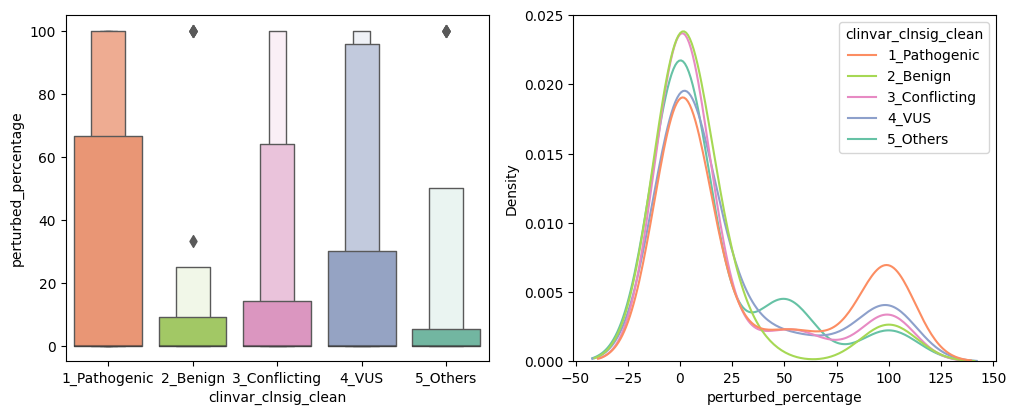

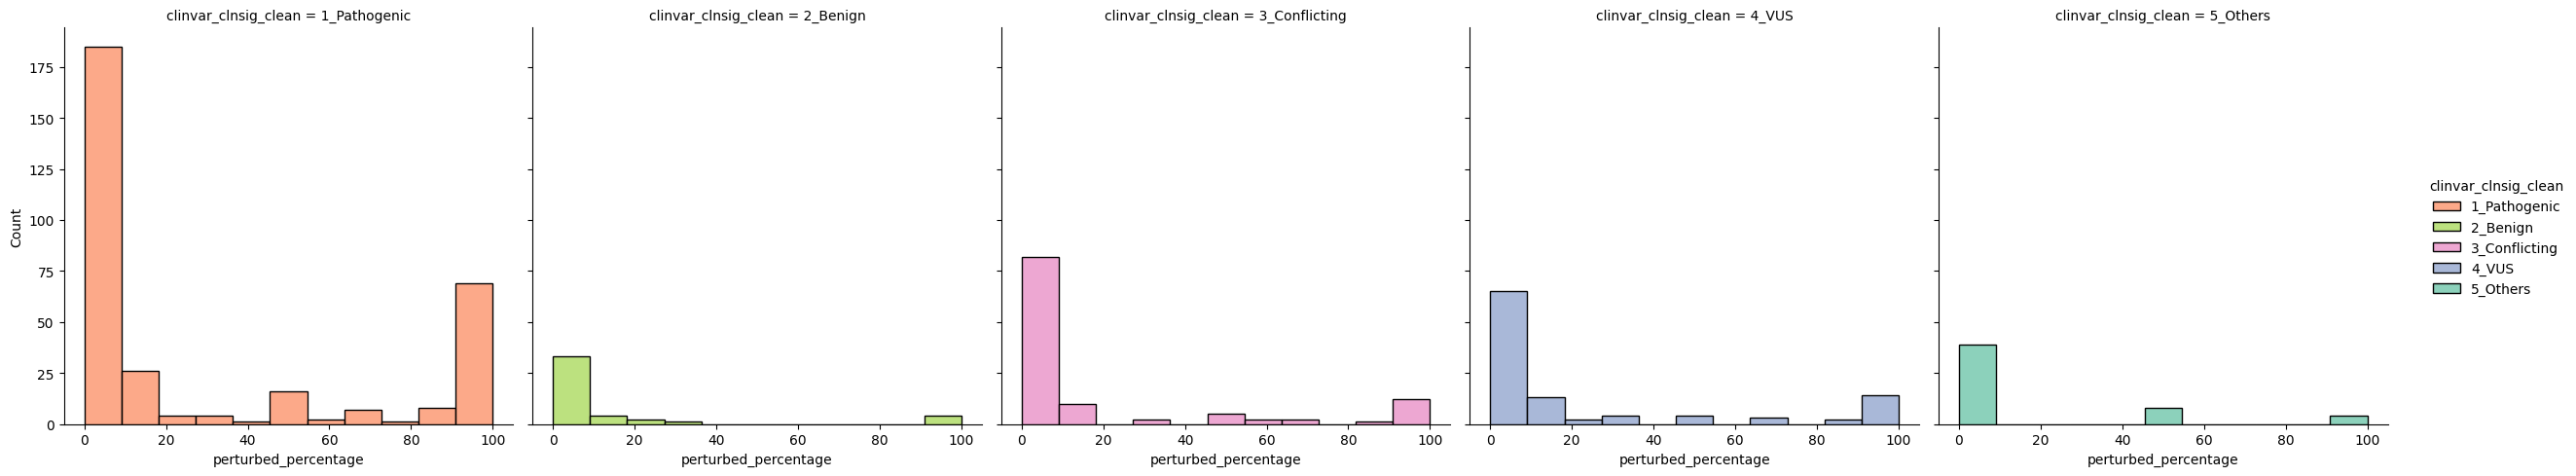

In [13]:
# edgotyping_clinvar_sum = (
#     variant_ppi_perturb_stats_clinvar
#       .group_by(["clinvar_clnsig_clean", "edgotype_wt_final"])
#       .len()
#       .sort(by="clinvar_clnsig_clean")
#       .rename({"len": "count"})
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").fill_null("6_NoClinVar")
# ).to_pandas()

# # Compute the total count PER clinvar_clnsig_clean (as a Series aligned to df.index):
# totals = edgotyping_clinvar_sum.groupby("clinvar_clnsig_clean")["count"].transform("sum")

# # Now compute percentage = count ÷ total_for_that_clinvar × 100
# edgotyping_clinvar_sum["percentage"] = edgotyping_clinvar_sum["count"] / totals * 100

fig, ax = plt.subplots(1,2, figsize=(12,4.5))
sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="perturbed_percentage", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="perturbed_percentage", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])

# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])

In [14]:
variant_ppi_perturb_stats_clinvar_gene = variant_ppi_perturb_stats_clinvar.group_by("symbol","clinvar_clnsig_clean").agg(
    pl.col("perturbed_percentage").mean().alias("perturb_perc_mean"),
    pl.col("perturbed_percentage").median().alias("perturb_perc_median")
)

variant_ppi_perturb_stats_clinvar_gene

symbol,clinvar_clnsig_clean,perturb_perc_mean,perturb_perc_median
str,str,f64,f64
"""PRKAR1A""","""1_Pathogenic""",0.0,0.0
"""TH""","""4_VUS""",14.285714,0.0
"""CAPN3""","""5_Others""",0.0,0.0
"""GALE""","""3_Conflicting""",0.0,0.0
"""AHCY""","""1_Pathogenic""",0.0,0.0
…,…,…,…
"""KCNJ2""","""4_VUS""",90.0,100.0
"""UROD""","""4_VUS""",0.0,0.0
"""PLP1""",null,88.89,88.89


<Figure size 640x480 with 0 Axes>

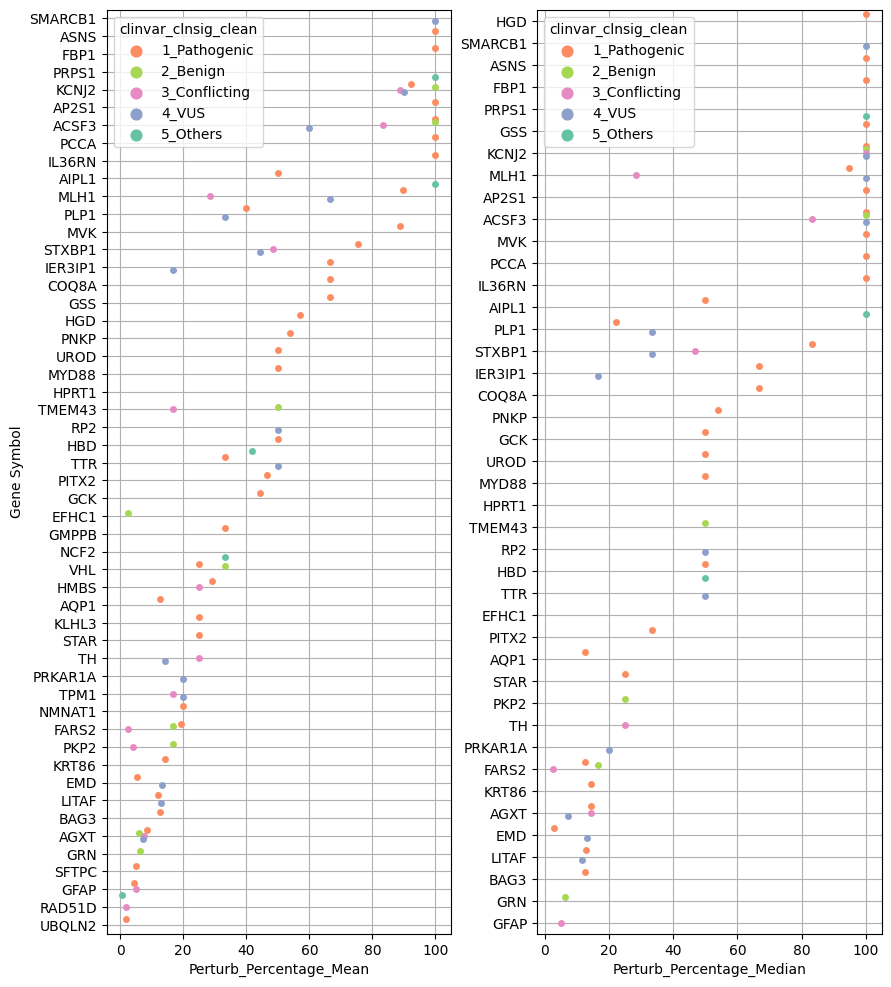

In [21]:
plt.clf()
hue_order = sorted(variant_ppi_perturb_stats_clinvar_gene.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
fig, ax = plt.subplots(1,2,figsize=(10, 12))
sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_mean")>0).sort("perturb_perc_mean", descending=True).select(
                pl.col(["perturb_perc_mean","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_mean", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            palette=palette_dict["clinvar_clnsig_clean"],
            dodge=True,
            hue_order=hue_order,
            ax=ax[0])
ax[0].set_xlabel("Perturb_Percentage_Mean")
ax[0].set_ylabel("Gene Symbol")
ax[0].grid()

sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_median")>0).sort("perturb_perc_median", descending=True).select(
                pl.col(["perturb_perc_median","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_median", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            dodge=True,
            palette=palette_dict["clinvar_clnsig_clean"],
            hue_order=hue_order,
            ax=ax[1])
ax[1].set_xlabel("Perturb_Percentage_Median")
ax[1].set_ylabel("")
ax[1].grid()
plt.subplots_adjust(wspace=0.25)
plt.show()

## 3. Map with Pillar Data

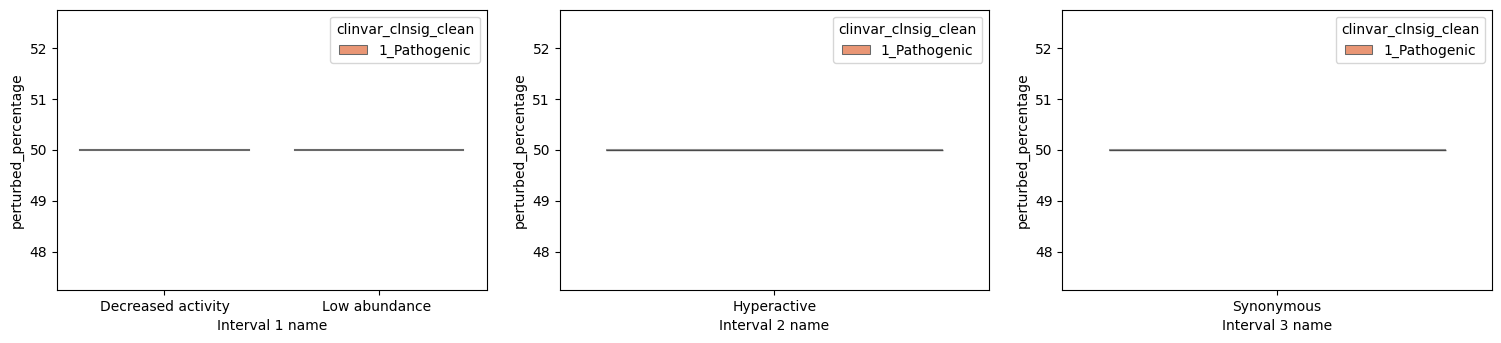

In [22]:
func_scores = variant_ppi_perturb_stats_clinvar.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

fig, axes = plt.subplots(2, 4, figsize=(25,8))
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.boxenplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y="perturbed_percentage",
            ax=axes.flatten()[i-1],
            palette=palette_dict["clinvar_clnsig_clean"], 
            hue="clinvar_clnsig_clean", 
            hue_order=hue_order,
            dodge=True,
        )
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.17)
plt.show()

## 4. Find optimal threshold for hits

### Noise-signal decomposition strategy specifically designed for discrete genomic datasets by:

* Identifying the central noise distribution using robust statistics (median, MAD)
* Separating outliers that represent potential biological signals
* Applying clustering to group similar outliers into biologically meaningful categories
* Optimizing classification thresholds for pathogenicity prediction

__1. Noise-Signal Separation__

Robust Background Detection:
```
python# Uses Median Absolute Deviation (MAD) for outlier-resistant estimation
median_val = np.median(data)
mad = np.median(np.abs(data - median_val))
noise_bounds = median_val ± (threshold × mad)
```
Scientific Justification:

MAD is robust to outliers compared to standard deviation
Median-based approach handles skewed distributions common in genomic data
Adaptive threshold adjusts to data-specific noise levels

__2. Signal Clustering (DBSCAN)__

Outlier Grouping:
```
python# Clusters outliers to identify distinct biological phenomena
clustering = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = clustering.fit_predict(signal_data)
```
Advantages for Genomic Data:

No assumption of cluster number: Discovers natural groupings
Handles noise points: Isolated outliers remain unassigned
Density-based: Groups signals by proximity in measurement space

__3. Multi-Method Threshold Optimization__

Three complementary approaches:

Method 1: Noise Boundary Threshold

Uses the upper bound of the null distribution's noise region

Rationale: Values beyond normal variation are potentially pathogenic

Method 2: Statistical Threshold

Sets threshold at μ_null - k×σ_null (typically k=2.5)

Rationale: Captures statistical significance based on null distribution

Method 3: Optimization-Based Threshold

Maximizes combined accuracy across both classes

Rationale: Finds optimal decision boundary through systematic search

In [25]:
class DiscreteDistributionAnalyzer:
    """
    Analyzer specifically designed for discrete/sparse genomic data with main cluster + outliers
    """
    
    def __init__(self, data_dict, noise_threshold=2.0):
        """
        Initialize with data dictionary
        noise_threshold: values within this range of median are considered 'noise/background'
        """
        self.data_dict = data_dict
        self.noise_threshold = noise_threshold
        self.analysis_results = {}
        
    def analyze_distribution(self, category):
        """
        Analyze distribution by separating background noise from real signals
        """
        data = self.data_dict[category]
        
        # Identify background/noise distribution (main cluster around 0)
        median_val = np.median(data)
        mad = np.median(np.abs(data - median_val))  # Median Absolute Deviation
        
        # Define noise region (most data should be here)
        noise_lower = median_val - self.noise_threshold * mad if mad > 0 else median_val - self.noise_threshold
        noise_upper = median_val + self.noise_threshold * mad if mad > 0 else median_val + self.noise_threshold
        
        # Separate noise from signals
        noise_mask = (data >= noise_lower) & (data <= noise_upper)
        noise_data = data[noise_mask]
        signal_data = data[~noise_mask]
        
        # Analyze noise distribution (should be single Gaussian)
        noise_mean = np.mean(noise_data)
        noise_std = np.std(noise_data)
        noise_fraction = len(noise_data) / len(data)
        
        # Analyze signals (outliers)
        if len(signal_data) > 0:
            # Separate positive and negative signals
            pos_signals = signal_data[signal_data > noise_upper]
            neg_signals = signal_data[signal_data < noise_lower]
            
            # Cluster signals to identify distinct groups
            signal_clusters = self._cluster_signals(signal_data)
        else:
            pos_signals = np.array([])
            neg_signals = np.array([])
            signal_clusters = []
        
        # Store results
        self.analysis_results[category] = {
            'noise_data': noise_data,
            'signal_data': signal_data,
            'noise_mean': noise_mean,
            'noise_std': noise_std,
            'noise_fraction': noise_fraction,
            'pos_signals': pos_signals,
            'neg_signals': neg_signals,
            'signal_clusters': signal_clusters,
            'n_signals': len(signal_data),
            'noise_bounds': (noise_lower, noise_upper)
        }
        
        return self.analysis_results[category]
    
    def _cluster_signals(self, signal_data, eps=5.0, min_samples=2):
        """
        Cluster signal data to identify distinct groups of outliers
        """
        if len(signal_data) < 2:
            return []
        
        # Use DBSCAN for clustering signals
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clustering.fit_predict(signal_data.reshape(-1, 1))
        
        clusters = []
        for label in set(labels):
            if label == -1:  # Noise points in DBSCAN
                continue
            cluster_data = signal_data[labels == label]
            clusters.append({
                'center': np.mean(cluster_data),
                'size': len(cluster_data),
                'data': cluster_data,
                'label': label
            })
        
        return clusters
    
    def analyze_all_categories(self):
        """
        Analyze all categories
        """
        for category in self.data_dict.keys():
            print(f"Analyzing {category}...")
            self.analyze_distribution(category)
    
    def plot_distributions_analyzed(self, figsize=(15, 10)):
        """
        Plot distributions with noise/signal separation
        """
        n_categories = len(self.data_dict)
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        colors = ['red', 'blue', 'green', 'purple']
        for i, (category, data) in enumerate(self.data_dict.items()):
            ax = axes[i]
            
            if category not in self.analysis_results:
                continue
                
            result = self.analysis_results[category]
            
            # Plot full histogram
            n_bins = min(50, max(10, len(np.unique(data))//2))
            ax.hist(data, bins=n_bins, density=True, alpha=0.4, 
                    color=colors[i], label=f'{category} (All Data)')
            
            # Highlight noise region
            if len(result['noise_data']) > 0:
                ax.hist(result['noise_data'], bins=n_bins, density=True, alpha=0.6, 
                        color=colors[i], label=f'Background/Noise ({result["noise_fraction"]:.1%})')
                
                # Fit and plot Gaussian for noise
                x_noise = np.linspace(result['noise_data'].min(), result['noise_data'].max(), 100)
                noise_pdf = stats.norm.pdf(x_noise, result['noise_mean'], result['noise_std'])
                ax.plot(x_noise, noise_pdf, '--', color='black', linewidth=2, 
                       label=f'Noise Model (μ={result["noise_mean"]:.2f})')
            
            # Mark signal regions
            if len(result['signal_data']) > 0:
                ax.scatter(result['signal_data'], 
                          np.zeros(len(result['signal_data'])), 
                          color='red', s=50, alpha=0.8, marker='x', 
                          label=f'Signals ({result["n_signals"]})')
            
            # Mark noise boundaries
            noise_lower, noise_upper = result['noise_bounds']
            ax.axvline(noise_lower, color='gray', linestyle=':', alpha=0.7)
            ax.axvline(noise_upper, color='gray', linestyle=':', alpha=0.7)
            
            ax.set_title(f'{category}\n(Noise: {result["noise_fraction"]:.1%}, Signals: {result["n_signals"]})')
            ax.set_xlabel('zscore_log2')
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def find_pathogenic_threshold(self, null_category='2_Benign', target_category='1_Pathogenic'):
        """
        Find threshold based on noise vs signal separation
        """
        if null_category not in self.analysis_results or target_category not in self.analysis_results:
            raise ValueError("Categories must be analyzed first")
        
        null_result = self.analysis_results[null_category]
        target_result = self.analysis_results[target_category]
        
        # Method 1: Use null noise boundary
        null_noise_upper = null_result['noise_bounds'][1]
        
        # Method 2: Use statistical approach on noise distributions
        # Set threshold at null_mean - k*null_std to capture most null as non-pathogenic
        k = 2.5  # Conservative threshold
        threshold_statistical = null_result['noise_mean'] - k * null_result['noise_std']
        
        # Method 3: Find threshold that maximizes separation
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        
        def objective(threshold):
            # We want pathogenic to be < threshold, benign to be >= threshold
            null_correct = np.sum(null_data >= threshold) / len(null_data)
            target_correct = np.sum(target_data < threshold) / len(target_data)
            return -(null_correct + target_correct)  # Maximize sum of accuracies
        
        from scipy.optimize import minimize_scalar
        min_val = min(null_data.min(), target_data.min())
        max_val = max(null_data.max(), target_data.max())
        
        result = minimize_scalar(objective, bounds=(min_val, max_val), method='bounded')
        threshold_optimal = result.x
        
        # Evaluate all thresholds
        thresholds = {
            'noise_boundary': null_noise_upper,
            'statistical': threshold_statistical,
            'optimal': threshold_optimal
        }
        
        results = {}
        for name, thresh in thresholds.items():
            null_correct = np.sum(null_data >= thresh) / len(null_data)
            target_correct = np.sum(target_data < thresh) / len(target_data)
            
            tp = np.sum(target_data < thresh)
            fp = np.sum(null_data < thresh)
            fn = np.sum(target_data >= thresh)
            tn = np.sum(null_data >= thresh)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            results[name] = {
                'threshold': thresh,
                'null_accuracy': null_correct,
                'target_accuracy': target_correct,
                'overall_accuracy': (null_correct + target_correct) / 2,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
            }
        
        # Choose best threshold based on F1 score
        best_method = max(results.keys(), key=lambda x: results[x]['f1_score'])
        
        return results[best_method], results
    
    def plot_threshold_analysis(self, null_category='2_Benign', 
                               target_category='1_Pathogenic', figsize=(15, 12)):
        """
        Comprehensive threshold analysis plot
        """
        best_result, all_results = self.find_pathogenic_threshold(null_category, target_category)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        null_result = self.analysis_results[null_category]
        target_result = self.analysis_results[target_category]
        
        # Plot 1: Distribution comparison with threshold
        n_bins = min(50, max(10, len(np.unique(np.concatenate([null_data, target_data])))//2))
        
        ax1.hist(null_data, bins=n_bins, density=True, alpha=0.6, 
                color='blue', label=f'{null_category}')
        ax1.hist(target_data, bins=n_bins, density=True, alpha=0.6, 
                color='red', label=f'{target_category}')
        
        # Add noise model for null
        x_range = np.linspace(null_data.min(), null_data.max(), 200)
        null_noise_pdf = stats.norm.pdf(x_range, null_result['noise_mean'], null_result['noise_std'])
        ax1.plot(x_range, null_noise_pdf, '--', color='blue', linewidth=2, alpha=0.8, 
                label='Null Noise Model')
        
        # Add threshold
        thresh = best_result['threshold']
        ax1.axvline(thresh, color='black', linestyle='-', linewidth=3, 
                   label=f'Optimal Threshold: {thresh:.2f}')
        
        # Mark noise boundaries
        ax1.axvline(null_result['noise_bounds'][0], color='gray', linestyle=':', alpha=0.5)
        ax1.axvline(null_result['noise_bounds'][1], color='gray', linestyle=':', alpha=0.5)
        
        ax1.set_xlabel('zscore_log2')
        ax1.set_ylabel('Density')
        ax1.set_title(f'Threshold Analysis: {null_category} vs {target_category}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Signal analysis
        ax2.scatter(range(len(null_result['signal_data'])), null_result['signal_data'], 
                   color='blue', alpha=0.6, label=f'{null_category} Signals')
        ax2.scatter(range(len(target_result['signal_data'])), target_result['signal_data'], 
                   color='red', alpha=0.6, label=f'{target_category} Signals')
        ax2.axhline(thresh, color='black', linestyle='-', linewidth=2, alpha=0.7)
        ax2.set_xlabel('Signal Index')
        ax2.set_ylabel('zscore_log2')
        ax2.set_title('Signal Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Method comparison
        methods = list(all_results.keys())
        f1_scores = [all_results[method]['f1_score'] for method in methods]
        
        bars = ax3.bar(methods, f1_scores, color=['green', 'orange', 'purple'])
        ax3.set_ylabel('F1 Score')
        ax3.set_title('Threshold Method Comparison')
        ax3.set_ylim(0, 1)
        
        for i, (bar, method) in enumerate(zip(bars, methods)):
            height = bar.get_height()
            thresh_val = all_results[method]['threshold']
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{thresh_val:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Confusion matrix visualization
        tp, fp, fn, tn = best_result['tp'], best_result['fp'], best_result['fn'], best_result['tn']
        confusion_data = np.array([[tn, fp], [fn, tp]])
        
        im = ax4.imshow(confusion_data, cmap='Blues', aspect='auto')
        ax4.set_xticks([0, 1])
        ax4.set_yticks([0, 1])
        ax4.set_xticklabels(['Predicted Benign', 'Predicted Pathogenic'])
        ax4.set_yticklabels(['Actual Benign', 'Actual Pathogenic'])
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                ax4.text(j, i, str(confusion_data[i, j]), ha='center', va='center', 
                        color='white' if confusion_data[i, j] > confusion_data.max()/2 else 'black',
                        fontsize=14, fontweight='bold')
        
        ax4.set_title('Confusion Matrix')
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"=== DISCRETE DISTRIBUTION ANALYSIS RESULTS ===")
        print(f"Best Threshold: {thresh:.3f}")
        print(f"Performance Metrics:")
        print(f"  - Precision: {best_result['precision']:.3f}")
        print(f"  - Recall: {best_result['recall']:.3f}")
        print(f"  - F1 Score: {best_result['f1_score']:.3f}")
        print(f"  - Overall Accuracy: {best_result['overall_accuracy']:.3f}")
        
        print(f"\nDistribution Characteristics:")
        print(f"  {null_category}: {null_result['noise_fraction']:.1%} noise, {null_result['n_signals']} signals")
        print(f"  {target_category}: {target_result['noise_fraction']:.1%} noise, {target_result['n_signals']} signals")
    
    def generate_summary_report(self):
        """Generate summary report for discrete distribution analysis"""
        print("=== DISCRETE DISTRIBUTION ANALYSIS REPORT ===")
        
        for category, result in self.analysis_results.items():
            print(f"\n{category}:")
            print(f"  - Total data points: {len(self.data_dict[category])}")
            print(f"  - Background/Noise fraction: {result['noise_fraction']:.3f}")
            print(f"  - Signal points: {result['n_signals']}")
            print(f"  - Noise distribution: μ={result['noise_mean']:.3f}, σ={result['noise_std']:.3f}")
            print(f"  - Positive signals: {len(result['pos_signals'])}")
            print(f"  - Negative signals: {len(result['neg_signals'])}")
            print(f"  - Signal clusters: {len(result['signal_clusters'])}")
            
            if result['signal_clusters']:
                for i, cluster in enumerate(result['signal_clusters']):
                    print(f"    Cluster {i+1}: center={cluster['center']:.2f}, size={cluster['size']}")

Analyzing 1_Pathogenic...
Analyzing 2_Benign...
Analyzing 3_Conflicting...
Analyzing 4_VUS...


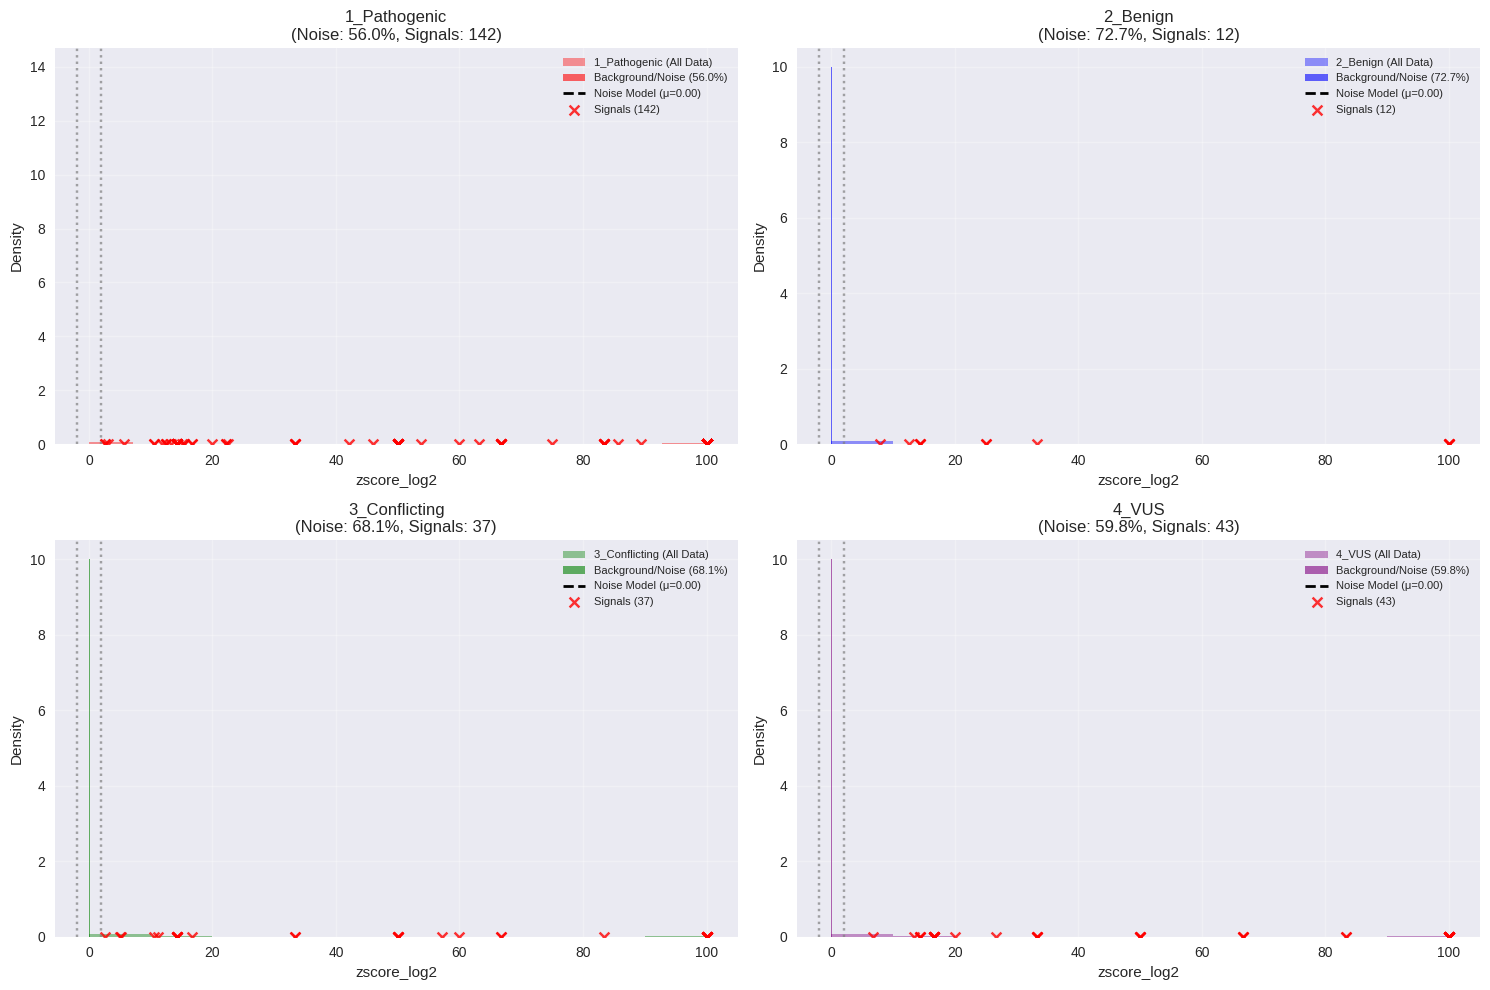

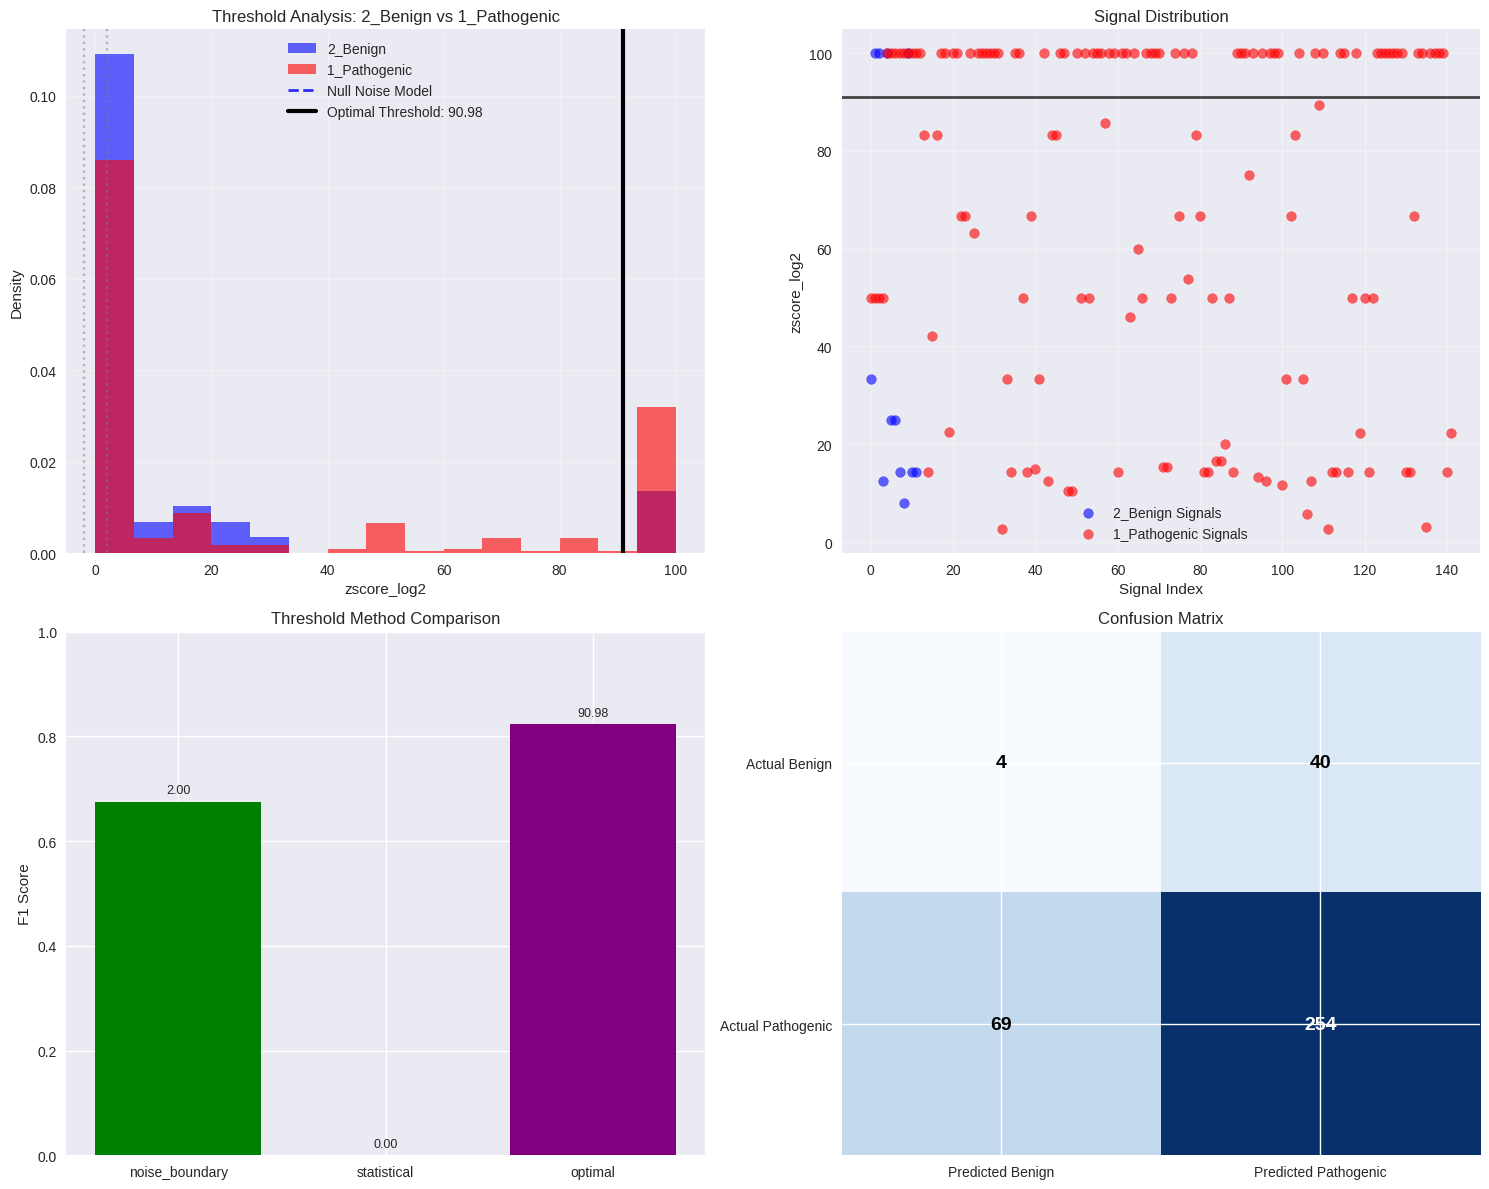

=== DISCRETE DISTRIBUTION ANALYSIS RESULTS ===
Best Threshold: 90.983
Performance Metrics:
  - Precision: 0.864
  - Recall: 0.786
  - F1 Score: 0.823
  - Overall Accuracy: 0.439

Distribution Characteristics:
  2_Benign: 72.7% noise, 12 signals
  1_Pathogenic: 56.0% noise, 142 signals
=== DISCRETE DISTRIBUTION ANALYSIS REPORT ===

1_Pathogenic:
  - Total data points: 323
  - Background/Noise fraction: 0.560
  - Signal points: 142
  - Noise distribution: μ=0.000, σ=0.000
  - Positive signals: 142
  - Negative signals: 0
  - Signal clusters: 6
    Cluster 1: center=49.52, size=17
    Cluster 2: center=100.00, size=69
    Cluster 3: center=84.40, size=8
    Cluster 4: center=13.64, size=34
    Cluster 5: center=65.54, size=9
    Cluster 6: center=33.33, size=4

2_Benign:
  - Total data points: 44
  - Background/Noise fraction: 0.727
  - Signal points: 12
  - Noise distribution: μ=0.000, σ=0.000
  - Positive signals: 12
  - Negative signals: 0
  - Signal clusters: 3
    Cluster 1: center=1

In [26]:
clinvar_data_dict = {
    '1_Pathogenic': variant_ppi_perturb_stats_clinvar.filter(pl.col('clinvar_clnsig_clean')=='1_Pathogenic')['perturbed_percentage'].to_numpy(),
    '2_Benign': variant_ppi_perturb_stats_clinvar.filter(pl.col('clinvar_clnsig_clean')=='2_Benign')['perturbed_percentage'].to_numpy(),
    '3_Conflicting': variant_ppi_perturb_stats_clinvar.filter(pl.col('clinvar_clnsig_clean')=='3_Conflicting')['perturbed_percentage'].to_numpy(),
    '4_VUS': variant_ppi_perturb_stats_clinvar.filter(pl.col('clinvar_clnsig_clean')=='4_VUS')['perturbed_percentage'].to_numpy(),
}

# Use the new analyzer
analyzer = DiscreteDistributionAnalyzer(clinvar_data_dict, noise_threshold=2.0)

# Analyze all distributions
analyzer.analyze_all_categories()

# Plot with proper noise/signal separation
analyzer.plot_distributions_analyzed()

# Find optimal threshold
analyzer.plot_threshold_analysis()

# Generate report
analyzer.generate_summary_report()